In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

#Metrics
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.preprocessing import OrdinalEncoder
random_state = 42

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Data Preprocessing

### Handling Missing Values

In [3]:
# Remove rows with missing values in 'MasVnrType', 'MasVnrArea', and 'Electrical' columns.
df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'], inplace=True)

In [4]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [5]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [6]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [7]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [8]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

### Encoding

In [9]:
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu',
                    'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [10]:
df = pd.get_dummies(df, columns = nominalFeatures)

In [11]:
ordinalCategories = [['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] for _ in ordinalFeatures]

ordinalEncoder = OrdinalEncoder(categories=ordinalCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[ordinalFeatures])

for i, feature in enumerate(ordinalFeatures):
    df[feature] = ordinalEncoded[:, i]

In [12]:
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

ordinalEncoder = OrdinalEncoder(categories=encodingCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[otherOrdinalFeatures])

for i, feature in enumerate(otherOrdinalFeatures):
    df[feature] = ordinalEncoded[:, i]

### Splitting DataSet

In [13]:
df_cp = df.copy()
y = df_cp.pop('SalePrice')
X = df_cp

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [15]:
print(X_train.shape)
print(X_test.shape)

(1160, 224)
(291, 224)


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1295 to 1132
Columns: 224 entries, Id to PavedDrive_Y
dtypes: float64(17), int64(34), uint8(173)
memory usage: 667.2 KB


In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 540 to 1310
Columns: 224 entries, Id to PavedDrive_Y
dtypes: float64(17), int64(34), uint8(173)
memory usage: 167.4 KB


## Gaussian Model

In [16]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
y_pred = gaussian.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating precision
precision = precision_score(y_test, y_pred, average='micro')

# Calculating recall
recall = recall_score(y_test, y_pred, average='micro')

# Printing the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.013745704467353952
Precision: 0.013745704467353952
Recall: 0.013745704467353952


Parece ser que en este punto el modelo es muy malo prediciendo dado que tiene una precisión muy bajo, de tan solo 0.013.

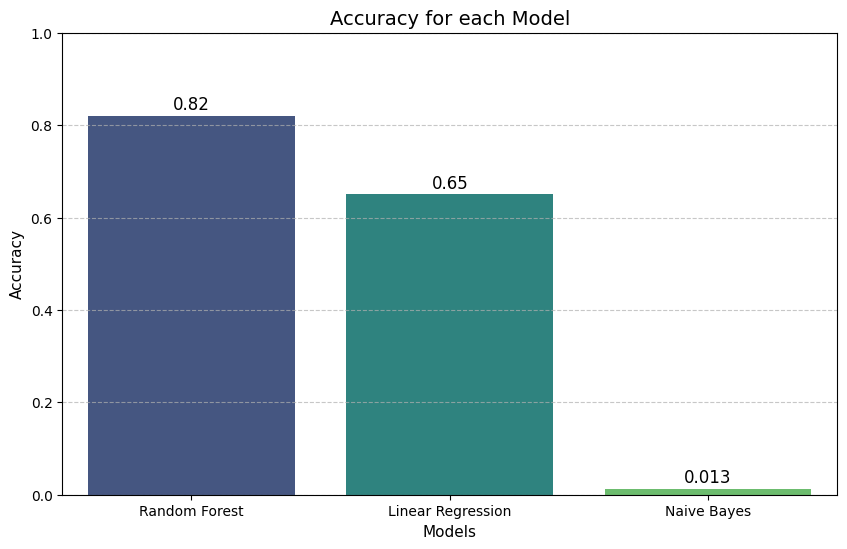

In [27]:
# Data for the graph
x_dataGraph = ['Random Forest', 'Linear Regression', 'Naive Bayes']
accuracyDataGraph = [0.82, 0.65, 0.013]

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(x=x_dataGraph, y=accuracyDataGraph, palette="viridis", hue=x_dataGraph)
plt.title('Accuracy for each Model', fontsize=14)
plt.xlabel('Models', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0, 1)  # Adjust the y-axis limits according to your data range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracyDataGraph):
    plt.text(i, v + 0.005, str(v), ha='center', va='bottom', fontsize=12)

plt.show()

Claramente, y basándonos en el siguiente gráfico, parece ser que el mejor modelo de predicción sigue siendo sin duda alguna el Random Forest, con una precisión de 0.82, alrededor de 0.20 más en cmparación a la regresión lineal y 0.80 más en comparación a Naive Bayes.

#### New Feature

In [28]:
# Make another copy of the dataframe
df_cp = df.copy()

# Define conditions for categorizing SalePrice
conditions = [
    (df_cp['SalePrice'] < 150000),
    (df_cp['SalePrice'] >= 150000) & (df_cp['SalePrice'] <= 250000),
    (df_cp['SalePrice'] > 250000)
]

# Define labels for the categories
labels = ['economical', 'intermediate', 'expensive']

# Create a new column 'SalePriceCategory' based on the conditions and labels
df_cp['SalePriceCategory'] = np.select(conditions, labels)

df_cp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory
0,1,60,65.0,8450,7,5,2003,2003,196.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
1,2,20,80.0,9600,6,8,1976,1976,0.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
2,3,60,68.0,11250,7,5,2001,2002,162.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
3,4,70,60.0,9550,7,5,1915,1970,0.0,3.0,...,1,0,0,0,0,0,0,0,1,economical
4,5,60,84.0,14260,8,5,2000,2000,350.0,4.0,...,0,0,0,0,1,0,0,0,1,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,3.0,...,0,0,0,0,1,0,0,0,1,intermediate
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,5.0,...,0,0,0,0,1,0,0,0,1,expensive
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,3.0,...,0,0,0,0,1,0,0,0,1,economical




A partir del análisis exploratorio de datos realizado, se observó que la variable SalePrice presenta una serie de datos atípicos y no sigue una distribución normal. La concentración predominante de los valores de venta se sitúa entre 150,000 y 250,000 dólares, tal como se refleja en el análisis cuartílico. Teniendo en cuenta estas observaciones, se propone una clasificación de las viviendas en función de su precio de venta para facilitar el análisis y la interpretación de los datos. Esta clasificación es la siguiente:

- Casas de gama alta: corresponden a aquellas propiedades cuyo precio excede los 250,000 dólares.

- Casas de gama media: este grupo incluye las viviendas con precios que oscilan entre 150,000 y 250,000 dólares.

- Casas económicas: se refiere a las viviendas cuyo precio es inferior a 150,000 dólares.



In [29]:
# Separate the target variable 'SalePriceCategory' from features
y = df_cp.pop('SalePriceCategory')

# Exclude columns 'Id' and 'SalePrice' from features
X = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice'])]

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [32]:
print(X_train.shape)
print(X_test.shape)

(1160, 223)
(291, 223)


In [33]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
y_pred = gaussian.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[112   0  16]
 [  0  42   4]
 [ 18  17  82]]


In [34]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating precision
precision = precision_score(y_test, y_pred, average='micro')

# Calculating recall
recall = recall_score(y_test, y_pred, average='micro')

# Printing the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8109965635738832
Precision: 0.8109965635738832
Recall: 0.8109965635738832


Analsis aqui

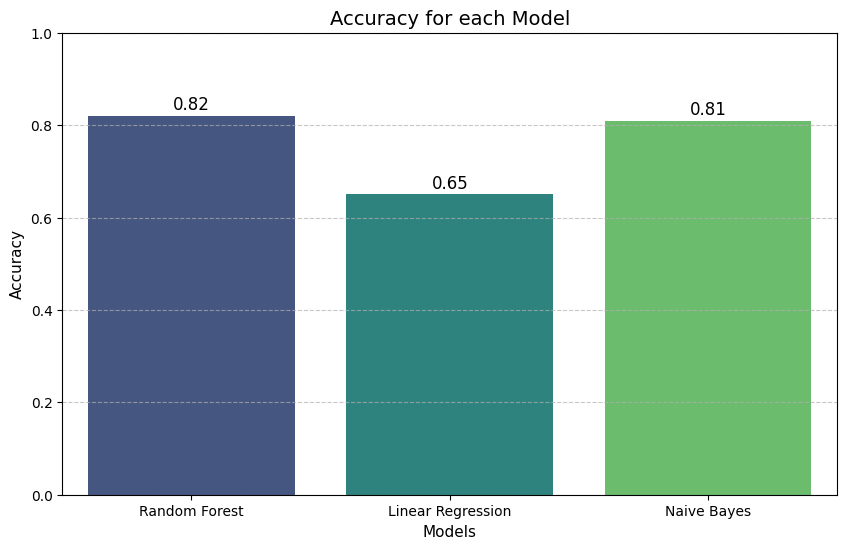

In [35]:
# Data for the graph
x_dataGraph = ['Random Forest', 'Linear Regression', 'Naive Bayes']
accuracyDataGraph = [0.82, 0.65, 0.81]

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(x=x_dataGraph, y=accuracyDataGraph, palette="viridis", hue=x_dataGraph)
plt.title('Accuracy for each Model', fontsize=14)
plt.xlabel('Models', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0, 1)  # Adjust the y-axis limits according to your data range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracyDataGraph):
    plt.text(i, v + 0.005, str(v), ha='center', va='bottom', fontsize=12)

plt.show()